In [27]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
import dipy.reconst.sfm as sfm
import dipy.reconst.csdeconv as csd
import dipy.reconst.dti as dti
import dipy.core.gradients as grad

In [3]:
import utils
from model import Model, BiExponentialIsotropicModel, my_responses

In [4]:
data = utils.read_data()

In [5]:
all_bvals = data['seen']['bvals']
unique_bvals = np.unique(all_bvals)
b0s_idx = np.where(all_bvals==0)

In [6]:
vox_idx = 0

In [7]:
train_data = []
train_bvals = []
train_bvecs = []
train_delta = []
train_Delta = []
train_te = []
train_g = []

for this_bv in unique_bvals[1:][::2]:
    idx = np.where(all_bvals == this_bv)
    train_data.append(data['seen']['signal'][:, vox_idx][idx])
    train_bvals.append(data['seen']['bvals'][idx])
    train_bvecs.append(data['seen']['bvecs'][idx])
    train_delta.append(data['seen']['delta'][idx])
    train_Delta.append(data['seen']['Delta'][idx])
    train_te.append(data['seen']['TE'][idx])
    train_g.append(data['seen']['g'][idx])

train_data = np.hstack(train_data)
train_bvals = np.hstack(train_bvals)
train_bvecs = np.vstack(train_bvecs)
train_delta = np.hstack(train_delta)
train_Delta = np.hstack(train_Delta)
train_te = np.hstack(train_te)
train_g = np.hstack(train_g)
    
train_data = np.hstack([train_data, data['seen']['signal'][:, vox_idx][b0s_idx[::2]]])
train_bvals = np.hstack([train_bvals, data['seen']['bvals'][b0s_idx[::2]]])
train_bvecs = np.vstack([train_bvecs, data['seen']['bvecs'][b0s_idx[::2]]])
train_delta = np.hstack([train_delta, data['seen']['delta'][b0s_idx[::2]]])
train_Delta = np.hstack([train_Delta, data['seen']['Delta'][b0s_idx[::2]]])
train_te = np.hstack([train_te, data['seen']['TE'][b0s_idx[::2]]])
train_g = np.hstack([train_g, data['seen']['g'][b0s_idx[::2]]])
    
    
test_data = []
test_bvals = []
test_bvecs = []
test_delta = []
test_Delta = []
test_te = []
test_g = []

    
for this_bv in unique_bvals[1:][1::2]:
    idx = np.where(all_bvals == this_bv)
    test_data.append(data['seen']['signal'][:, vox_idx][idx])
    test_bvals.append(data['seen']['bvals'][idx])
    test_bvecs.append(data['seen']['bvecs'][idx])
    test_delta.append(data['seen']['delta'][idx])
    test_Delta.append(data['seen']['Delta'][idx])
    test_te.append(data['seen']['TE'][idx])
    test_g.append(data['seen']['g'][idx])

test_data = np.hstack(test_data)
test_bvals = np.hstack(test_bvals)
test_bvecs = np.vstack(test_bvecs)
test_delta = np.hstack(test_delta)
test_Delta = np.hstack(test_Delta)
test_te = np.hstack(test_te)
test_g = np.hstack(test_g)

test_data = np.hstack([test_data, data['seen']['signal'][:, vox_idx][b0s_idx[1::2]]])
test_bvals = np.hstack([test_bvals, data['seen']['bvals'][b0s_idx[1::2]]])
test_bvecs = np.vstack([test_bvecs, data['seen']['bvecs'][b0s_idx[1::2]]])
test_delta = np.hstack([test_delta, data['seen']['delta'][b0s_idx[1::2]]])
test_Delta = np.hstack([test_Delta, data['seen']['Delta'][b0s_idx[1::2]]])
test_te = np.hstack([test_te, data['seen']['TE'][b0s_idx[1::2]]])
test_g = np.hstack([test_g, data['seen']['g'][b0s_idx[1::2]]])

In [8]:
train_gtab = grad.gradient_table(train_bvals, train_bvecs, big_delta=train_Delta, small_delta=train_delta)
test_gtab = grad.gradient_table(test_bvals, test_bvecs, big_delta=test_Delta, small_delta=test_delta)

In [9]:
train_s0 = train_data[train_gtab.b0s_mask]

In [10]:
import sklearn.linear_model as lm
model1 = Model(train_gtab, isotropic=BiExponentialIsotropicModel, 
               solver=lm.ElasticNet(l1_ratio=0.1, alpha=1e-5, positive=True, warm_start=True, max_iter=25000, 
                                                                               fit_intercept=True, normalize=True))

model2 = Model(test_gtab, isotropic=BiExponentialIsotropicModel, 
               solver=lm.ElasticNet(l1_ratio=0.1, alpha=1e-5, positive=True, warm_start=True, max_iter=25000, 
                                                                fit_intercept=True, normalize=True))

In [11]:
fit1 = model1.fit(train_data, train_te, train_g)
fit2 = model2.fit(test_data, test_te, test_g)

In [12]:
predict1= fit1.predict(test_gtab, test_te)
predict2= fit2.predict(train_gtab, train_te)

In [13]:
utils.LSE(predict1, test_data), utils.LSE(predict2, train_data) 

(1.8154528208908798, 2.7447681533537449)

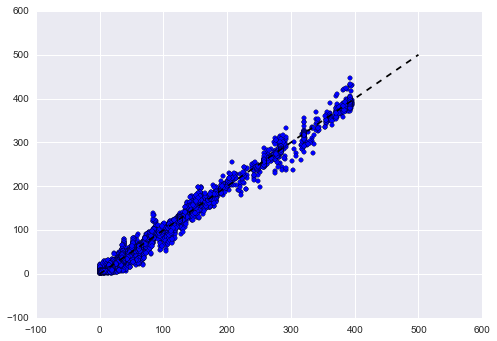

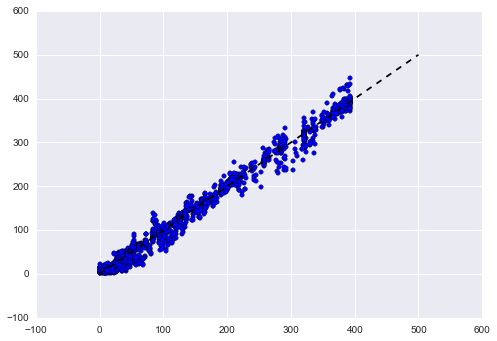

In [31]:
fig, ax = plt.subplots(1)
plt.scatter(predict1, test_data)
plt.plot([0, 500], [0, 500], 'k--')

fig, ax = plt.subplots(1)
plt.scatter(predict2, train_data)
plt.plot([0, 500], [0, 500], 'k--')


In [32]:
GG = np.unique(train_g) 

In [33]:
GG

array([   0.,   58.,   59.,   60.,   61.,   63.,   86.,  100.,  190.,
        192.,  199.,  200.,  275.,  289.,  292.])

In [34]:
GG = np.unique(test_g) 

In [35]:
GG

array([   0.,   34.,   58.,   59.,   60.,   61.,   63.,   86.,   99.,
        100.,  101.,  103.,  190.,  192.,  199.,  200.,  201.,  275.,
        289.,  290.,  291.,  292.])